(18202, 70, 1)


c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



torch.Size([30, 70, 1])
torch.Size([70, 30, 1])
torch.Size([70, 30, 1])


tensor(162.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

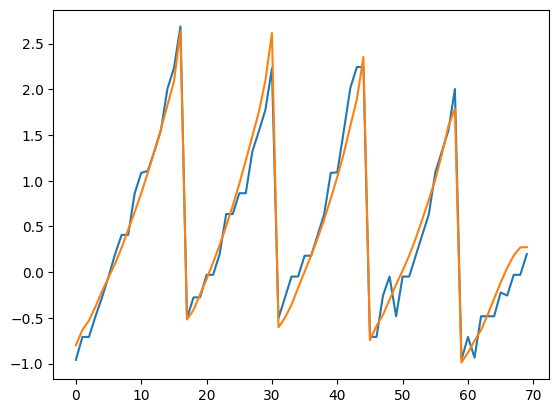

In [1]:
## full import+training code

#%matplotlib widget
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn   
import pandas as pd
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

df = pd.read_pickle(fr'C:\Users\achfr\OneDrive - University of Edinburgh\Compiled dataset\df_compiled_mothers_labelled_cyclefate.csv')
df_tracks= df.pivot(values=[
    'GrowthRateSize','GrowthRateLength','GrowthRateFeretMax','GrowthRateFeretMaxSliding',
    'InterdivisionTimes','DivisionRate','DivisionRate_filtered','TrackLength','TrackLength_filtered',
    'Size','SizeAtBirthSize','FeretMax','SizeAtBirthFeretMax','MaxLength','SpineLength','SizeAtBirthLength','SpineWidth',
    'MeanIntensity_mch','MeanIntensity_gfp','Maxgfp',
    'BacteriaLineage','NextDivisionFrame','PreviousDivisionFrame',
    'TrackHeadIndices','Prev','Next','Idx','Frame','Indices','PositionIdx','cellcycle_fate'], 
    index=['Position','ParentTrackHeadIndices','Medium','Treatment','RepeatID','RepeatDate','fate','DeathSubtype'],
    columns='Time')

exp_name = 'glu_cip_1'

medium,treatment,replicate = exp_name.split('_')

skip_timepoints = 1
if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint

frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])
fates = np.array([i for i in frame.reset_index('fate')['fate']])
death_subtypes = np.array([i for i in frame.reset_index('DeathSubtype')['DeathSubtype']])


liste=[]
for i in range(size_array.shape[0]):
    serie =  size_array[i]
    t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
    usable_data = serie[24:min(t_death,168)]
    seq_len = 70
    # for i in range(len(usable_data)//seq_len):  #splitting the data into sequences of length seq_len
    #     tre = (i+1)*seq_len
    #     liste.append(usable_data[tre-seq_len:tre])
    for i in range(0,len(usable_data)-seq_len,1):
        liste.append(usable_data[i:i+seq_len])
        
X_train = np.array(np.random.permutation(liste))[:,:,:]

# X_train, X_test = Data[:int(0.9*Data.shape[0])], Data[int(0.9*Data.shape[0]):]

train_dataset = TensorDataset(torch.from_numpy(X_train))
# test_dataset = TensorDataset(torch.from_numpy(X_test))

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

print(X_train.shape)

dload = './model_dir_mm' #download directory
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 30
learning_rate = 0.0005
n_epochs = 200
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=200
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

# vrae.fit(train_dataset, save=True)
# file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
# losses = []
# for line in file:
#     if 'Average loss' in line:
#         losses.append(float(line.split(' ')[-1][:-2]))
# plt.plot(losses)
vrae.load(fr'C:\Users\achfr\timeseries-clustering-vae\it_worked\model_200ep.pth')

vrae.eval()
testseq = train_dataset[30:batch_size+30][0].float()
print(testseq.shape)
# plt.plot(testseq[:,:,0].T)
testseq2 = testseq.permute(1, 0, 2).cuda()
print(testseq2.shape)
outp = vrae.forward(testseq2)
print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)

loss = nn.MSELoss(reduction='sum')
loss(testseq2, outp[0])

#19min 200ep glu ctrl 2

In [2]:
# create dataset with all size trajectories of living cells

dataset_name_list = ['gly_control_1', 'gly_control_2', 'gly_control_3', 'gly_cip_1', 'gly_cip_2', 'gly_tet_1', 'gly_tet_2', 'gly_tet_3', 'gly_ciptet_1', 'gly_ciptet_2', 'glu_control_1', 'glu_control_2', 'glu_cip_1', 'glu_cip_2', 
 'glu_tet_1', 'glu_tet_2', 'glu_ciptet_1', 'glu_ciptet_2', 'gluaa_control_1', 'gluaa_control_2', 'gluaa_cip_1', 'gluaa_cip_2', 'gluaa_cip_3', 'gluaa_tet_1', 'gluaa_tet_2', 'gluaa_ciptet_1', 'gluaa_ciptet_2']
dataset_lengths = [188,376,304,252,307,317,277,411,328,431, 78,342,386,377,351,354,355,350,283,334,218,191,235,327,237,343,304]

gigadataset_X = []
gigadataset_Y = []
giga_other_stuff = []

for_heatmap = []
for_heatmap_unscaled = []

for exp_name in dataset_name_list:
    print(exp_name)
    medium,treatment,replicate = exp_name.split('_')

    skip_timepoints = 1
    if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint

    frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
    size_array_unscaled = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
    size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array_unscaled)
    elongation_rate_array = np.array([list(frame['GrowthRateFeretMax'].T[k]) for k in frame['GrowthRateFeretMax'].T.keys()])
    cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])
    fates = np.array([i for i in frame.reset_index('fate')['fate']])
    death_subtypes = np.array([i for i in frame.reset_index('DeathSubtype')['DeathSubtype']])

    for i in range(size_array.shape[0]):
            for_heatmap.append(size_array[i])
            for_heatmap_unscaled.append(size_array_unscaled[i])
            serie =  size_array[i,[cyclefate_array[i,k]=='alive' for k in range(0,size_array.shape[1])]]
            # t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
            cropped_serie = serie[24//skip_timepoints:min((72+24)//skip_timepoints,len(serie))] # uses first 6 hours or until death
            if len(cropped_serie) >0:
                gigadataset_X.append(torch.from_numpy(cropped_serie))
                gigadataset_Y.append((medium,treatment,replicate,fates[i],death_subtypes[i],len(cropped_serie)))
                dict_other_stuff = {'elongation_rate':torch.from_numpy(elongation_rate_array[i]),'cyclefate':cyclefate_array[i]}
                giga_other_stuff.append(dict_other_stuff)

from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset

class PackedSequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.lengths = [len(seq) for seq in data]

    def __getitem__(self, index):
        sequence = self.data[index]
        length = self.lengths[index]
        packed_sequence = pack_padded_sequence(sequence.unsqueeze(0), [length], batch_first=True, enforce_sorted=False)
        return packed_sequence.data, length

    def __len__(self):
        return len(self.data)

# Create the dataset
dataset = PackedSequenceDataset(gigadataset_X)

label_map = {
    ('gly', 'control'): 0,
    ('gly', 'cip'): 1,
    ('gly', 'tet'): 2,
    ('gly', 'ciptet'): 3,
    ('glu', 'control'): 4,
    ('glu', 'cip'): 5,
    ('glu', 'tet'): 6,
    ('glu', 'ciptet'): 7,
    ('gluaa', 'control'): 8,
    ('gluaa', 'cip'): 9,
    ('gluaa', 'tet'): 10,
    ('gluaa', 'ciptet'): 11
}

labels = [label_map[k[:2]] for k in gigadataset_Y]

# 1min - 1min30

gly_control_1
gly_control_2
gly_control_3
gly_cip_1
gly_cip_2
gly_tet_1
gly_tet_2
gly_tet_3
gly_ciptet_1
gly_ciptet_2
glu_control_1
glu_control_2
glu_cip_1
glu_cip_2
glu_tet_1
glu_tet_2
glu_ciptet_1
glu_ciptet_2
gluaa_control_1
gluaa_control_2
gluaa_cip_1
gluaa_cip_2
gluaa_cip_3
gluaa_tet_1
gluaa_tet_2
gluaa_ciptet_1
gluaa_ciptet_2


In [3]:
# encodes all the data
vrae.batch_size = 1
projected_comme_jamaid = vrae.transform(dataset)
# vrae.batch_size = 30
# decoded = vrae.reconstruct(TensorDataset(torch.from_numpy((projected_comme_jamaid)).unsqueeze(-1)))

# plot_clustering(projected_comme_jamaid, labels, engine='matplotlib', download = False) # function from paper

In [ ]:
### heatmap code
list_heat = for_heatmap

arr = np.zeros((len(list_heat),300))

for i in range(len(list_heat)):
    serie = list_heat[i]
    for k in range(1,len(serie)-1):
        if np.isnan(serie[k]):
            serie[k] = (serie[k-1]+serie[k+1])/2
    arr[i,:min(len(serie),300)] = serie[:300,0]

dataset_name_list = ['gly_control_1', 'gly_control_2', 'gly_control_3', 'gly_cip_1', 'gly_cip_2', 'gly_tet_1', 'gly_tet_2', 'gly_tet_3', 'gly_ciptet_1', 'gly_ciptet_2', 'glu_control_1', 'glu_control_2', 'glu_cip_1', 'glu_cip_2', 
 'glu_tet_1', 'glu_tet_2', 'glu_ciptet_1', 'glu_ciptet_2', 'gluaa_control_1', 'gluaa_control_2', 'gluaa_cip_1', 'gluaa_cip_2', 'gluaa_cip_3', 'gluaa_tet_1', 'gluaa_tet_2', 'gluaa_ciptet_1', 'gluaa_ciptet_2']
dataset_lengths = [188,376,304,252,307,317,277,411,328,431, 78,342,386,377,351,354,355,350,283,334,218,191,235,327,237,343,304]
import seaborn as sns
fig,ax = plt.subplots(figsize=(50,10))
sns.heatmap(arr[:,:].T, ax=ax, cmap='cubehelix', xticklabels=[], yticklabels=[], vmin=-2.5, vmax=2.5)
ax.axhline(y=24, color='black', linestyle='--')
ax.axhline(y=168, color='black', linestyle='--')

Text(0.5, 1.0, 'PCA on z_run gluaa')

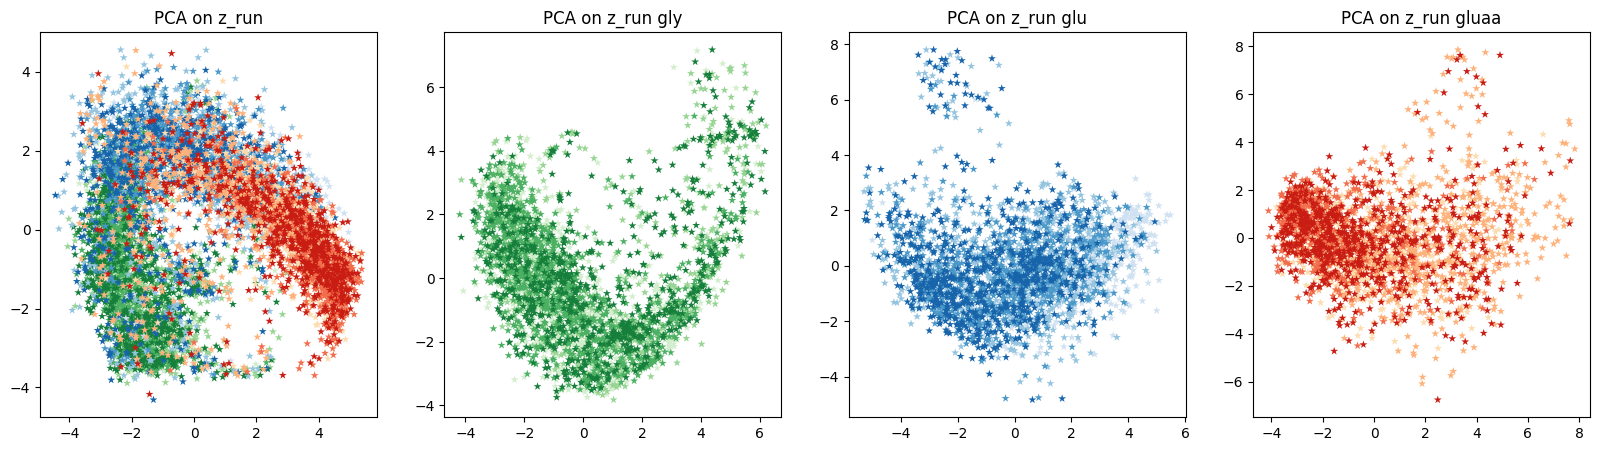

In [131]:
# PCA (and tsne)
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scale_center_before = True

fig,ax = plt.subplots(1,4,figsize=(20,5))

# Create color palettes
green_palette = sns.color_palette("Greens", 4)
blue_palette = sns.color_palette("Blues", 4)
orange_red_palette = sns.color_palette("OrRd", 4)
bourpalette = green_palette + blue_palette + orange_red_palette


# whole data pca
if scale_center_before: z_run = scaler.fit_transform(projected_comme_jamaid)
else: z_run = projected_comme_jamaid
# z_run_pca_fit = TruncatedSVD(n_components=20).fit(z_run)
z_run_pca_fit =PCA(n_components=20).fit(z_run)
z_run_pca = z_run_pca_fit.transform(z_run)
hex_colors =  bourpalette
colors = [hex_colors[int(i)] for i in labels]
label_names = ['gly_control', 'gly_cip', 'gly_tet', 'gly_ciptet', 'glu_control', 'glu_cip', 'glu_tet', 'glu_ciptet', 'gluaa_control', 'gluaa_cip', 'gluaa_tet', 'gluaa_ciptet']
ax[0].scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[0].set_title('PCA on z_run')

# # only gly pca
if scale_center_before:z_run_gly = scaler.fit_transform(projected_comme_jamaid[[k[0] == 'gly' for k in gigadataset_Y],:])
else: z_run_gly = projected_comme_jamaid[[k[0] == 'gly' for k in gigadataset_Y],:]
z_run_gly_pca_fit = TruncatedSVD(n_components=20).fit(z_run_gly)
z_run_gly_pca = z_run_gly_pca_fit.transform(z_run_gly)
hex_colors =  green_palette
colors = [hex_colors[int(i)] for i in labels if i in [0,1,2,3]]
label_names = ['gly_control', 'gly_cip', 'gly_tet', 'gly_ciptet']
ax[1].scatter(z_run_gly_pca[:, 0], z_run_gly_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[1].set_title('PCA on z_run gly')

# only glu pca
if scale_center_before:z_run_glu = scaler.fit_transform(projected_comme_jamaid[[k[0] == 'glu' for k in gigadataset_Y],:])
else: z_run_glu = projected_comme_jamaid[[k[0] == 'glu' for k in gigadataset_Y],:]
z_run_glu_pca_fit = TruncatedSVD(n_components=20).fit(z_run_glu)
z_run_glu_pca = z_run_glu_pca_fit.transform(z_run_glu)
hex_colors =  blue_palette
colors = [hex_colors[int(i-4)] for i in labels if i in [4,5,6,7]]
label_names = ['glu_control', 'glu_cip', 'glu_tet', 'glu_ciptet']
ax[2].scatter(z_run_glu_pca[:, 0], z_run_glu_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[2].set_title('PCA on z_run glu')

# only gluaa pca
if scale_center_before:z_run_gluaa = scaler.fit_transform(projected_comme_jamaid[[k[0] == 'gluaa' for k in gigadataset_Y],:])
else: z_run_gluaa = projected_comme_jamaid[[k[0] == 'gluaa' for k in gigadataset_Y],:]
z_run_gluaa_pca_fit = TruncatedSVD(n_components=20).fit(z_run_gluaa)
z_run_gluaa_pca = z_run_gluaa_pca_fit.transform(z_run_gluaa)
hex_colors =  orange_red_palette
colors = [hex_colors[int(i-8)] for i in labels if i in [8,9,10,11]]
label_names = ['gluaa_control', 'gluaa_cip', 'gluaa_tet', 'gluaa_ciptet']
ax[3].scatter(z_run_gluaa_pca[:, 0], z_run_gluaa_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[3].set_title('PCA on z_run gluaa')

# from sklearn.manifold import TSNE
# z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)
# plt.scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
# plt.title('tSNE on z_run')
# plt.show()

In [52]:
z_run_gly_pca_fit.singular_values_

array([165.13423  ,  96.60645  ,  47.399967 ,  43.542645 ,  42.070618 ,
        29.58794  ,  24.237392 ,  20.825674 ,  19.22939  ,  16.719908 ,
        15.025665 ,  11.919055 ,  10.01743  ,   8.560493 ,   6.713216 ,
         6.2820315,   5.6476808,   4.197391 ,   3.1639638,   2.6340659],
      dtype=float32)

In [ ]:
# t-SNE all dataset widget

import matplotlib.pyplot as plt
from ipywidgets import interact, Checkbox, HBox, VBox, interactive_output

# Create a dictionary of checkboxes, one for each label
checkboxes = {label: Checkbox(value=True, description=label) for label in label_names}

from ipywidgets import Button

# Create buttons to check and uncheck all checkboxes
check_all_button = Button(description="Check all")
uncheck_all_button = Button(description="Uncheck all")

# Define the button click events
def check_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = True

def uncheck_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = False

# Attach the events to the buttons
check_all_button.on_click(check_all)
uncheck_all_button.on_click(uncheck_all)

# Create a grid of checkboxes with the buttons
checkboxes_grid = VBox([HBox(list(checkboxes.values())[i:i+4]) for i in range(0, len(checkboxes), 4)] + 
                       [HBox([check_all_button, uncheck_all_button])])


def plot(**checkbox_values):
    plt.figure(figsize=(10, 10))
    # For each label, if the checkbox is checked, plot the points with that label
    for label, checked in checkbox_values.items():
        if checked:
            # Get the index of the label
            label_index = label_names.index(label)
            # Get the points with this label
            points = z_run_tsne[[k==label_index for k in labels],:]
            # Plot the points
            plt.scatter(points[:, 0], points[:, 1], c=np.array([hex_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    plt.ylim(-75,75)
    plt.xlim(-75,85)
    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed
    plt.show()

# Create interactive output
out = interactive_output(plot, checkboxes)

# Display the checkboxes and the output
display(checkboxes_grid, out)

In [ ]:
# survived/died plots

label_map = {
    ('survived'): 0,
    ('died'): 1,
    ('hyperfila'): 1,
    ('persister'): 0
}

labels_death = [label_map[k[3]] for k in gigadataset_Y]
label_names = ['survived', 'died']
death_colors = ['blue','red']
plot_type = 'pca'

plt.figure(figsize=(10, 10))
for label in label_names:
    print(label)
    # Get the index of the label
    label_index = label_names.index(label)
    # Get the points with this label
    if plot_type == 'pca':
        points = z_run_pca[[k==label_index for k in labels_death],:]
    else:
        points = z_run_tsne[[k==label_index for k in labels_death],:]
    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], c=np.array([death_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    if plot_type == 'tsne':
        plt.ylim(-75,75)
        plt.xlim(-75,85)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
    else:
        plt.ylim(-2,5)
        plt.xlim(-5,5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed

In [ ]:
### 3d
rate_means = []
for i in range(len(giga_other_stuff)):
    rate_means.append(np.mean(giga_other_stuff[i]['elongation_rate'][giga_other_stuff[i]['cyclefate']=='alive'][-20:].numpy()))


import matplotlib.cm as cm
import matplotlib.colors as colors


# Normalize rate_means to range [0, 1]
# norm = colors.Normalize(vmin=min(rate_means), vmax=max(rate_means))
norm = colors.Normalize(vmin=0.1, vmax=1.5)

# Create a colormap
colormap = cm.get_cmap('jet')

# Create a list of colors
color_list = [colormap(norm(value)) for value in rate_means]

fig = plt.figure(figsize=(10, 10))
# plt.scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=color_list, marker='*', linewidths=0)
ax = fig.add_subplot(projection='3d')
ax.scatter(z_run_pca[:, 0], z_run_pca[:, 1], z_run_pca[:, 2], c=color_list, marker='*', linewidths=0)




plt.title('PCA on z_run')
# plt.colorbar(label='Rate Means')
plt.ylim(-2,5)
plt.xlim(-5,5)
plt.show()

In [ ]:
# only glu plot
z_run = projected_comme_jamaid

only_glu_z = z_run[[k[0]=='gly' for k in gigadataset_Y],:]
only_glu_y = [k for k in gigadataset_Y if k[0]=='gly']

only_glu_pca = TruncatedSVD(n_components=3).fit_transform(only_glu_z)
only_glu_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(only_glu_z)

label_map = {
    ('control'): 0,
    ('cip'): 1,
    ('tet'): 2,
    ('ciptet'): 3}

labels_glu = [label_map[k[1]] for k in only_glu_y]

label_names = ['control', 'cip', 'tet', 'ciptet']

# survived/died plots
import matplotlib.pyplot as plt

glu_colors = ['blue','red','green','pink']

plot_type = 'tsne'

plt.figure(figsize=(10, 10))
for label in label_names:
    print(label)
    # Get the index of the label
    label_index = label_names.index(label)
    # Get the points with this label
    if plot_type == 'pca':
        points = only_glu_pca[[k==label_index for k in labels_glu],:]
    else:
        points = only_glu_tsne[[k==label_index for k in labels_glu],:]
    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], c=np.array([glu_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    if plot_type == 'tsne':
        plt.ylim(-40,50)
        plt.xlim(-45,45)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
    else:
        plt.ylim(-5,5)
        plt.xlim(-5,5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed

plot_type = 'pca'

plt.figure(figsize=(10, 10))
for label in label_names:
    print(label)
    # Get the index of the label
    label_index = label_names.index(label)
    # Get the points with this label
    if plot_type == 'pca':
        points = only_glu_pca[[k==label_index for k in labels_glu],:]
    else:
        points = only_glu_tsne[[k==label_index for k in labels_glu],:]
    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], c=np.array([glu_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    if plot_type == 'tsne':
        plt.ylim(-40,50)
        plt.xlim(-45,45)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
    else:
        plt.ylim(-5,5)
        plt.xlim(-5,5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed

In [106]:
# PCA all dataset widget
import matplotlib.pyplot as plt
from ipywidgets import interact, Checkbox, HBox, VBox, interactive_output

# Create a dictionary of checkboxes, one for each label
checkboxes = {label: Checkbox(value=True, description=label) for label in label_names}

from ipywidgets import Button

# Create buttons to check and uncheck all checkboxes
check_all_button = Button(description="Check all")
uncheck_all_button = Button(description="Uncheck all")

# Define the button click events
def check_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = True

def uncheck_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = False

# Attach the events to the buttons
check_all_button.on_click(check_all)
uncheck_all_button.on_click(uncheck_all)

# Create a grid of checkboxes with the buttons
checkboxes_grid = VBox([HBox(list(checkboxes.values())[i:i+4]) for i in range(0, len(checkboxes), 4)] + 
                       [HBox([check_all_button, uncheck_all_button])])


def plot(**checkbox_values):
    plt.figure(figsize=(10, 10))
    # For each label, if the checkbox is checked, plot the points with that label
    for label, checked in checkbox_values.items():
        if checked:
            # Get the index of the label
            label_index = label_names.index(label)
            # Get the points with this label
            points = z_run_pca[[k==label_index for k in labels],:]
            # Plot the points
            plt.scatter(points[:, 0], points[:, 1], c=np.array([hex_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('PCA on z_run')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.ylim(-5,5)
    plt.xlim(-5,7)
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed
    plt.show()

# Create interactive output
out = interactive_output(plot, checkboxes)

# Display the checkboxes and the output
display(checkboxes_grid, out)


Output()

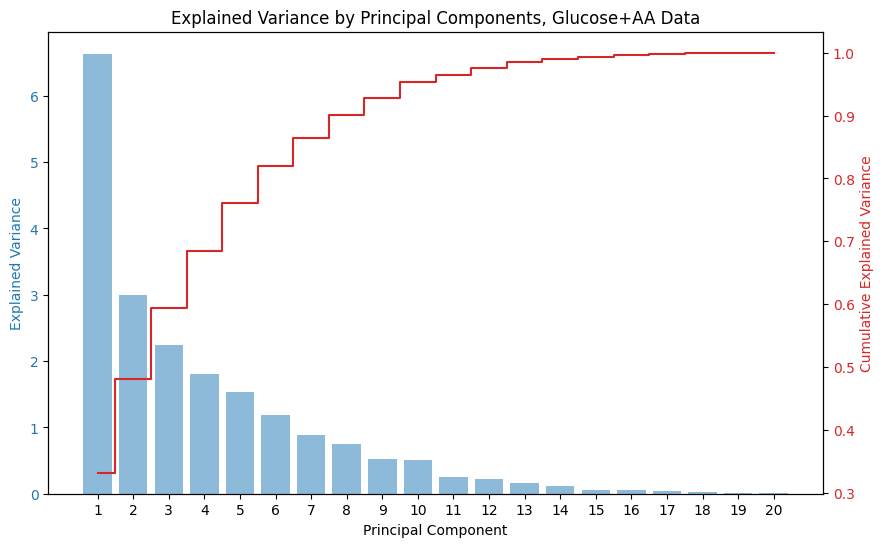

In [130]:
pca_object,title = z_run_pca_fit,'All Data'
pca_object,title = z_run_gly_pca_fit,'Glycerol Data'
pca_object,title = z_run_glu_pca_fit,'Glucose Data'
pca_object,title = z_run_gluaa_pca_fit,'Glucose+AA Data'

singular_values = pca_object.explained_variance_
explained_variance_ratio = pca_object.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a bar plot of the singular values
color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance', color=color)
ax1.bar(range(1, len(singular_values)+1), singular_values, alpha=0.5, align='center', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a line plot of the cumulative explained variance
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Cumulative Explained Variance', color=color)  # we already handled the x-label with ax1
ax2.step(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, where='mid', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Explained Variance by Principal Components, {title}')
plt.xticks(range(1, len(singular_values)+1))
plt.savefig(fr'C:\Users\achfr\phd\image dump.npy\truc.png')

In [124]:
np.sum(np.var(z_run_pca,axis=0))
np.sum(z_run_pca_fit.explained_variance_)

20.00246

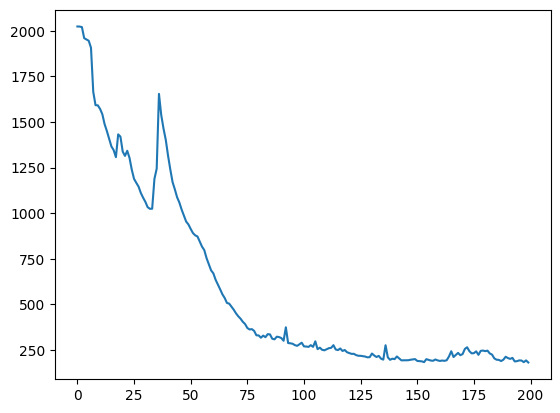

In [28]:
# plot epoch loss
file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
losses = []
for line in file:
    if 'Average loss' in line:
        losses.append(float(line.split(' ')[-1][:-2]))
plt.plot(losses)

In [ ]:
# plot recon expample
vrae.eval()
k1=np.random.randint(0,len(X_train)-batch_size)
testseq = torch.from_numpy(X_train[k1:k1+batch_size]).float()

# print(testseq.shape)
testseq2 = testseq.permute(1, 0, 2).cuda()
# print(testseq2.shape)
outp = vrae.forward(testseq2)
# print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)
import torch.nn as nn   
loss = nn.MSELoss(reduction='sum')
loss(testseq2, outp[0])
plt.legend(['input', 'output'])
plt.rcParams.update({'font.size': 15})
print(k1,k)